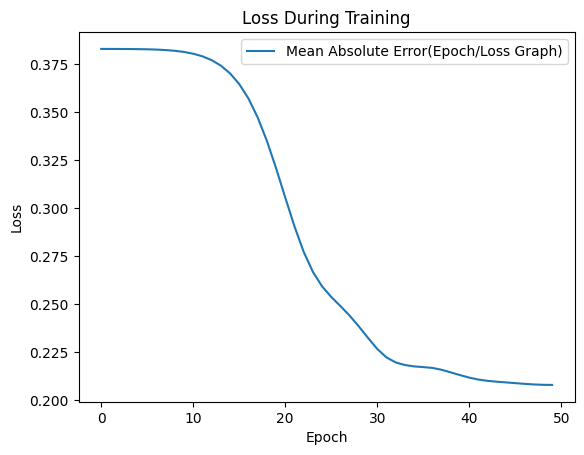

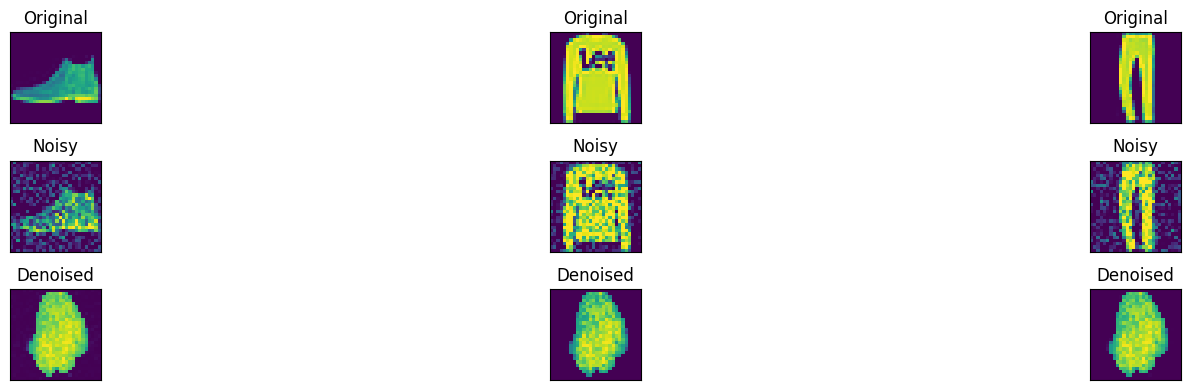

In [48]:
# imports
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Sigmoid activation function
# This is for the ouput layer, where it squashes the input values into a range between 0 and 1, making it suitable
# for generating the pixel values of the denoised images. The image pixel values are normalized the same way in the main()
def sigmoid(x):
    return 1.0 / (1.0 + tf.exp(-x))


# This function initializes the weights of the neurons across all layers
# Initialize the weights of the neurons to be random values from a normal distribution.
# Reference to use tf.random.normal() from BinaryLogisticRegression.ipynb 
def initialize_weights():
    # weights dictionary has all the learnable weights according to the assignment w1 - w6
    # provides a starting point for the optimization to adjust these weights and minimize error later during training
    weights = {
        'w1': tf.Variable(tf.random.normal([784, 128], mean=0.0, stddev=0.05), dtype=tf.float32),
        'w2': tf.Variable(tf.random.normal([128, 64], mean=0.0, stddev=0.05), dtype=tf.float32),
        'w3': tf.Variable(tf.random.normal([64, 32], mean=0.0, stddev=0.05), dtype=tf.float32),
        'w4': tf.Variable(tf.random.normal([32, 64], mean=0.0, stddev=0.05), dtype=tf.float32),
        'w5': tf.Variable(tf.random.normal([64, 128], mean=0.0, stddev=0.05), dtype=tf.float32),
        'w6': tf.Variable(tf.random.normal([128, 784], mean=0.0, stddev=0.05), dtype=tf.float32),
    }
    return weights

# A function called forward pass
# parameters X(matrix of feature data/input data), weights(learnable weights via dictionary)
def forward_pass(X, weights):
    # using tf.keras.activations.relu for the activation functions where required
    layer1 = tf.keras.activations.relu(tf.matmul(X, weights['w1']))
    layer2 = tf.keras.activations.relu(tf.matmul(layer1, weights['w2']))
    layer3 = tf.keras.activations.relu(tf.matmul(layer2, weights['w3']))
    layer4 = tf.keras.activations.relu(tf.matmul(layer3, weights['w4']))
    layer5 = tf.keras.activations.relu(tf.matmul(layer4, weights['w5']))
    # sigmoid layer is now manually implemented for the output layer
    output = sigmoid(tf.matmul(layer5, weights['w6']))

    # print(layer1.shape)
    # print(layer2.shape)
    # print(layer3.shape)
    # print(layer4.shape)
    # print(layer5.shape)
    # print(output.shape)

    return output

# A function called mean_absolute_error
# Parameters y_pred - ouput of the forward_pass (denoinsed images)
# Parameter y_true: Original non-noisy data
def mean_absolute_error(y_pred, y_true):
    absolute_errors = tf.abs(y_pred - y_true)
    # Calculate MAE across all instances and pixels
    # Alternative to reduce_sum
    mae = tf.reduce_mean(absolute_errors)
    return mae


# Referencing the BinaryLogisticRegression.ipynb from canvas here for the code
# train_step():  https://keras.io/examples/keras_recipes/trainer_pattern/
def train_step(model_weights, x_noisy, x_true, optimizer):
    # Create an instance of GradientTape to monitor the forward pass
    with tf.GradientTape() as tape:
        # Perform a forward pass and calculate the loss
        y_pred = forward_pass(x_noisy, model_weights)
        loss = mean_absolute_error(y_pred, x_true)
    # Calculate gradients with respect to model weights
    gradients = tape.gradient(loss, list(model_weights.values()))
    # Apply gradients to update model weights
    optimizer.apply_gradients(zip(gradients, list(model_weights.values())))
    return loss


def train(x_train_noisy, x_train, epochs, learning_rate):
    model_weights = initialize_weights()
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Visualization
    # According to my brief understanding, below is a graph having
    # epoch on the x and mae on the y. Saving the mae values for each epoch in a list
    # (losses) in order to display it.
    losses = []

    # Iterate our training loop
    for epoch in range(epochs):
        loss = train_step(model_weights, x_train_noisy, x_train, optimizer)
        losses.append(loss.numpy())

        # Uncomment this if you want to see it printed
        # print('Epoch', epoch + 1, ': Loss =', loss.numpy())

    # Plotting it
    plt.plot(losses, label='Mean Absolute Error(Epoch/Loss Graph)')
    plt.title('Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model_weights



# Reference: https://github.com/13muskanp/Image-Denoising-Using-Autoencoder/blob/master/Image%20Denoising%20using%20AutoEncoders.ipynb
def graph_original_noisy_denoised(x_test_noisy, x_test, model_weights, num_images):
    # Use the model to denoise test images
    denoised_images = forward_pass(x_test_noisy[:num_images], model_weights)

    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Original image
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.title("Original")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Noisy images
        ax = plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(x_test_noisy[i].numpy().reshape(28, 28))
        plt.title("Noisy")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Denoised (reconstructed) images
        ax = plt.subplot(3, num_images, i + 1 + num_images * 2)
        plt.imshow(denoised_images[i].numpy().reshape(28, 28))
        plt.title("Denoised")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.tight_layout()

    plt.show()


def main():

  learning_rate = 0.001
  epochs= 50# Number of iterations

  #Visualize num_images in the plt
  num_images = 3

  (x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

  # plt.imshow(x_train[0])
  # plt.show()

  # Normalize train and test data
  x_train = x_train.astype('float32') / 255.0
  x_test = x_test.astype('float32') / 255.0

  # Reshape so that each instance is a linear array of 784 normalized pixel values
  x_train = x_train.reshape((len(x_train), 784))
  x_test = x_test.reshape((len(x_test), 784))
  # print ("Shape of training feature data is ", x_train.shape)
  # print ("Shape of testing feature data is ", x_test.shape)

  # Add random noise to the image
  noise_factor = 0.2
  x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
  x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

  # Clip the resulting values so that they don't fall outside values of 0 and 1
  x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
  x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)
  # print (x_train.shape, x_test.shape)
  # print (x_train_noisy.shape, x_test_noisy.shape)

  # weights = initialize_weights()
  # # forward_pass(x_train_noisy, weights)
  # y_pred = forward_pass(x_train_noisy, weights)
  # loss =  mean_absolute_error(y_pred, x_train)

  # print("Mean Absolute Error:", loss.numpy())
  final_weights = train(x_train_noisy, x_train, epochs, learning_rate)

  # Visualize the denoising performance on test data
  graph_original_noisy_denoised(x_test_noisy, x_test, final_weights, num_images)



main()